# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- LSM

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [3]:
np.random.seed(1)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [4]:
PARAM_selection_size = 1000
PARAM_anomaly_size = int(0.1 * PARAM_selection_size)
PARAM_widnow_size = int(0.1 * PARAM_selection_size)

PARAM_normal_mean = 0
PARAM_normal_std = 10

PARAM_max_test_pow = 11

## Functions

In [5]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # remove trend from other data
    trend_data = df[trend_column].copy()
    for column in df.columns:
            df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [6]:
def lsm(y, pol_pow):
    """
    LSM
    y - 1d array of values,
    pol_pow - polynomial power of model
    """
    # Reshape y to row vector
    Y = y.reshape(-1, 1)
    # Creating F matrix, 1, x, x^2, ..., x^PARAM_max_pow
    F = np.ones((len(y), pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, len(y)), i)
    # calculations
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    C = np.dot(FFIFT, Y)
    result = np.dot(F, C)
    # returning array, reshaped from row vector to 1d
    return result.reshape(-1)

## Errors and anomalies

In [7]:
# normal error
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
# starting from PARAM_widnows_size to get std of normal error without anomalies
# (instead of manually removing anomalies from first window)
_normal_anomalies = _normal.copy()
for i in np.unique(np.random.randint(PARAM_widnow_size, PARAM_selection_size, PARAM_anomaly_size)):
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
        _normal_anomalies[i] *= 2

## Data

In [8]:
data = {}

# quadratic, + noise, + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomalies

describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies
count,"1,000.000","1,000.000","1,000.000"
mean,0.000,0.388,0.293
std,0.000,9.815,16.251
min,0.000,-30.538,-58.809
25%,0.000,-6.002,-6.663
50%,0.000,0.413,0.451
75%,0.000,7.040,7.849
max,0.000,39.586,58.436
var,0.000,96.333,264.086


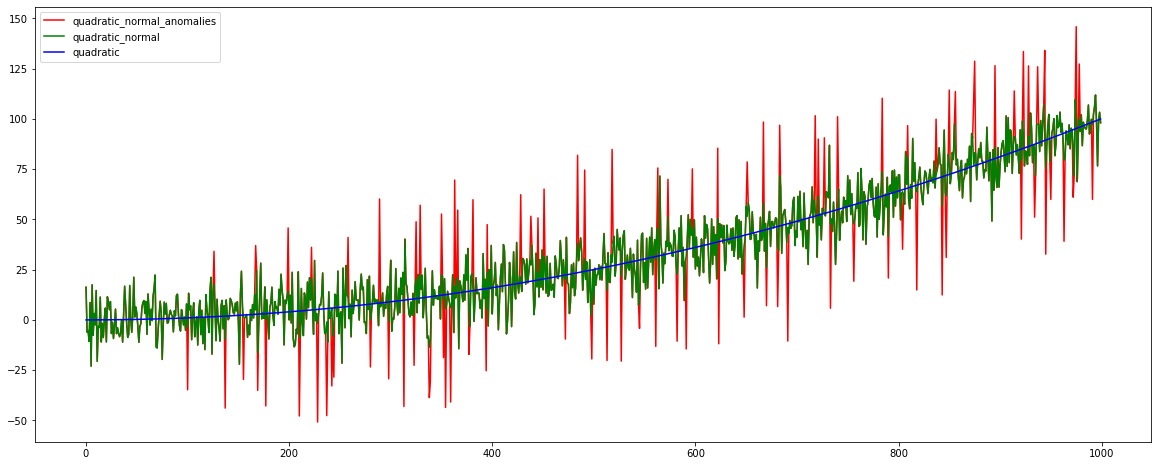

In [9]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="red")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.legend()
plt.show()

## Finding optimal polynomial power for smoothing

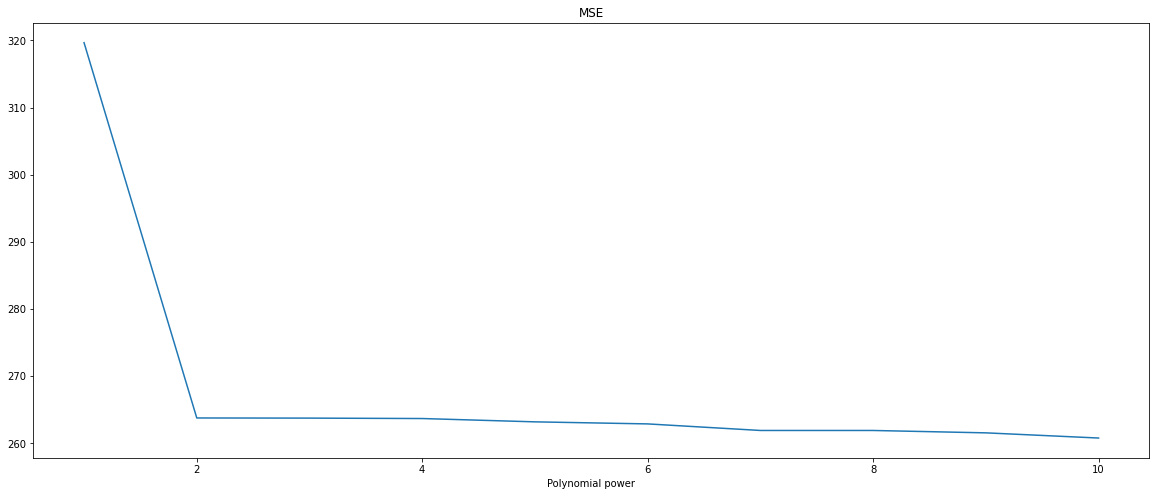

In [10]:
errs = []
pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append((np.square(data["quadratic_normal_anomalies"] - lsm(data["quadratic_normal_anomalies"], power))).mean())

plt.title("MSE")
plt.xlabel("Polynomial power")
plt.plot(pow_range, errs)
plt.show()

In [11]:
PARAM_best_pow = 2

## Detecting Anomalies with Sliding Window

In [12]:
data["quadratic_normal_anomalies_fix"] = data["quadratic_normal_anomalies"].copy()
window = data["quadratic_normal_anomalies_fix"][:PARAM_widnow_size]

std = abs((window - lsm(window, PARAM_best_pow)).std())
print("Estimated std:", std)

Estimated std: 8.777220951706228


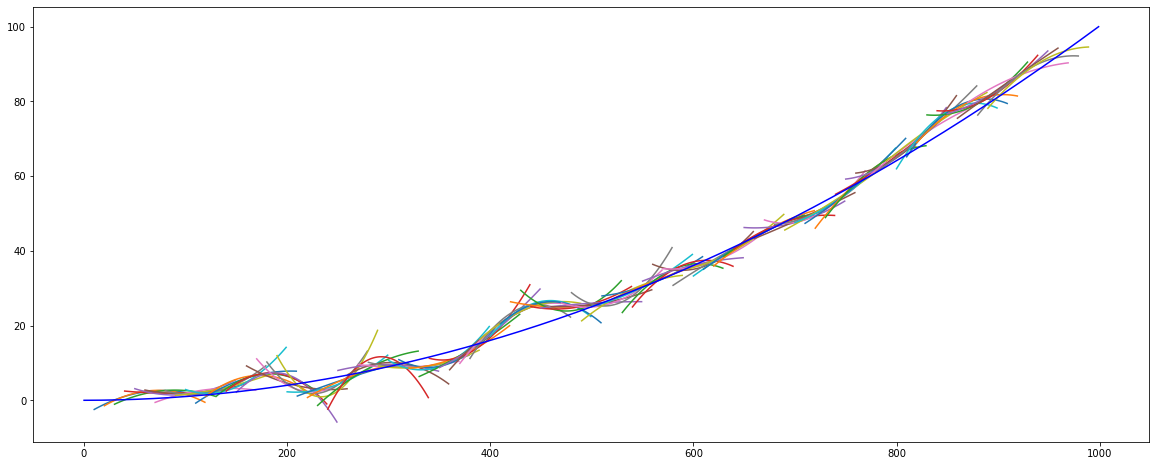

In [13]:
# save indexes and values of anomalies
anomaly_index = []
anomaly_value = []

for i in range(1, PARAM_selection_size - PARAM_widnow_size - 1):
    # new window
    widnow = data["quadratic_normal_anomalies_fix"][i:(PARAM_widnow_size + i)]
    # new fit to window
    window_lsm = lsm(widnow, PARAM_best_pow)
    # plot lsm
    if i % 10 == 0:
        plt.plot(range(i, (PARAM_widnow_size + i)), window_lsm)
    # if [new window std] >> [normal std]
    if abs((widnow - window_lsm).std()) > std:
        anomaly_index.append(PARAM_widnow_size + i - 1)
        anomaly_value.append(widnow[-1])
        data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i - 1] = \
            (data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i - 2] \
                + data["quadratic_normal_anomalies_fix"][PARAM_widnow_size + i]) \
                    / 2
plt.plot(data["quadratic"], c="blue")
plt.show()

## Detected anomalies

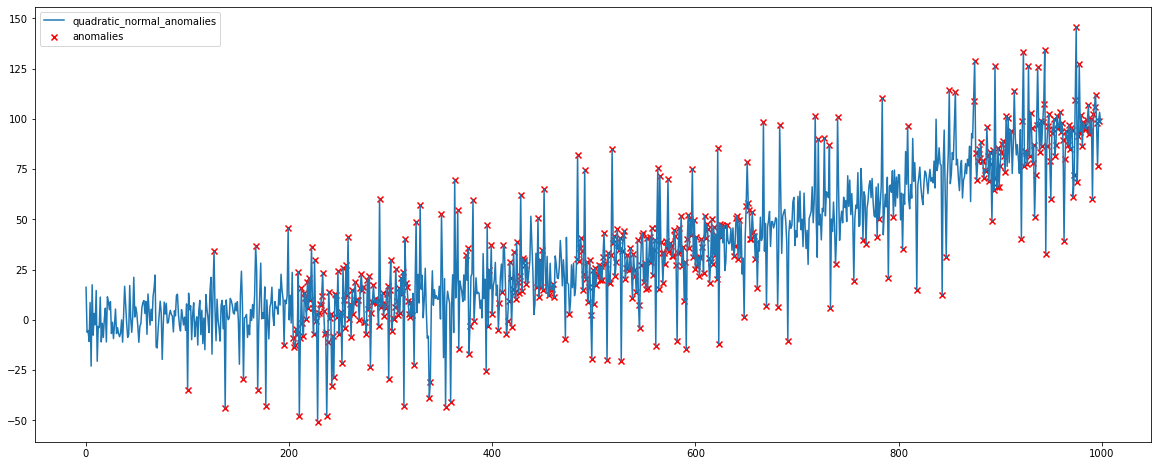

In [14]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.legend()
plt.show()

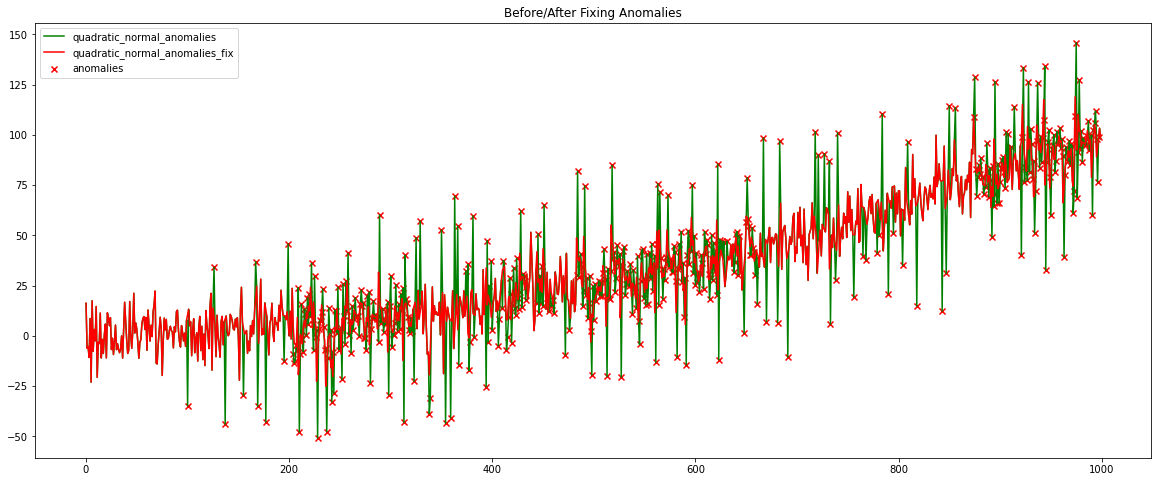

In [19]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="green")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="red")
plt.title("Before/After Fixing Anomalies")
plt.legend()
plt.show()

In [16]:
describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies,quadratic_normal_anomalies_fix
count,"1,000.000","1,000.000","1,000.000","1,000.000"
mean,0.000,0.388,0.293,0.626
std,0.000,9.815,16.251,9.345
min,0.000,-30.538,-58.809,-31.209
25%,0.000,-6.002,-6.663,-4.758
50%,0.000,0.413,0.451,0.499
75%,0.000,7.040,7.849,6.107
max,0.000,39.586,58.436,33.101
var,0.000,96.333,264.086,87.327


In [17]:
#plt.hist(data["quadratic_normal_anomalies"], bins=20, alpha=0.3, label="quadratic_normal_anomalies")